In [ ]:
from keras.datasets import boston_housing
from keras import models
from keras import layers
import numpy as np

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


# 정규화 (Standard Normal Distribution; Z-Distribution)
'''
상이한 스케일을 가지고 있는 데이터를 같은 스케일로 맞추어줌.
따라서 features 별로 정규화를 진행.
특성의 중앙이 0, 표준편차가 1
'''

mean = train_data.mean(axis=0) #평균
train_data -= mean #Data에서 평균을 뺴주고
std = train_data.std(axis=0) # 표준편차
train_data /= std #표준편차로 나누어준다.

'''
test_data를 정규화 할 때 train_data 정규화 값을 사용하는 것은
머신러닝 작업 과정에서는 절대로 test_data의 어떠한 계산 값도 사용해서는 안되기 때문임.
'''
test_data -= mean
test_data /= std




# Model 설정

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer='rmsprop', loss='mae', metrics=['mse'])
    return model

# mse(mean squared error) : 예측값과 실제값 차이의 제곱의 평균 -> 손실함수
# mae(mean absolute error) : 예측값에서 실제값을 뺸 절대값의 평균 -> 회귀 지표






# K-Fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
        print(i + 1, '번째 실행중')
    # validation data & targets 설정
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    # train data & targets 설정
    partial_train_data = np.concatenate(
    [
        train_data[ : i * num_val_samples],
        train_data[(i+1) * num_val_samples : ]
    ],axis = 0)
    
    partial_train_targets = np.concatenate(
    [
        train_targets[ : i * num_val_samples],
        train_targets[(i+1) * num_val_samples : ]
    ],axis = 0)
    
    # train
    model = build_model()
    model.fit(partial_train_data, 
              partial_train_targets,
              epochs = num_epochs,
              batch_size = 1,
              verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)
    
    
print(all_scores)
np.mean(all_scores)

In [4]:
# num_epochs = 500
# all_mae_histories = []

# for i in range(k):
#     print(i + 1, '번째 실행중')
#     # validation data & targets 설정
#     val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
#     val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
#     # train data & targets 설정
#     partial_train_data = np.concatenate(
#     [
#         train_data[ : i * num_val_samples],
#         train_data[(i+1) * num_val_samples : ]
#     ],axis = 0)
#     partial_train_targets = np.concatenate(
#     [
#         train_targets[ : i * num_val_samples],
#         train_targets[(i+1) * num_val_samples : ]
#     ],axis = 0)
    
#     # train
#     model = build_model()
#     history = model.fit(partial_train_data, 
#               partial_train_targets,
#               validation_data = (val_data,val_targets),
#               epochs = num_epochs,
#               batch_size = 1,
#               verbose = 0)
#     mae_history = history.history['val_mae']
#     all_mae_histories.append(mae_history)
    
    
# average_mae_history = [
#     np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
# ]



num_epochs = 500
all_mae_histories = []
all_val_mae_histories = []

for i in range(k):
    print(i + 1, '번째 실행중')
    # validation data & targets 설정
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    
    # train data & targets 설정
    partial_train_data = np.concatenate(
    [
        train_data[ : i * num_val_samples],
        train_data[(i+1) * num_val_samples : ]
    ],axis = 0)
    partial_train_targets = np.concatenate(
    [
        train_targets[ : i * num_val_samples],
        train_targets[(i+1) * num_val_samples : ]
    ],axis = 0)
    
    # train
    model = build_model()
    history = model.fit(partial_train_data, 
              partial_train_targets,
              validation_data = (val_data,val_targets),
              epochs = num_epochs,
              batch_size = 1,
              verbose = 0)
    mae_history = history.history['mae']
    val_mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    all_val_mae_histories.append(val_mae_history)
    
    
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

average_val_mae_history = [
    np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)
]

1 번째 실행중
2 번째 실행중
3 번째 실행중
4 번째 실행중


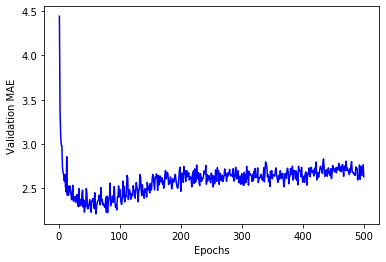

In [7]:
import matplotlib.pyplot as plt


# plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, 'red')
plt.plot(range(1, len(average_val_mae_history) + 1), average_val_mae_history, 'blue')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

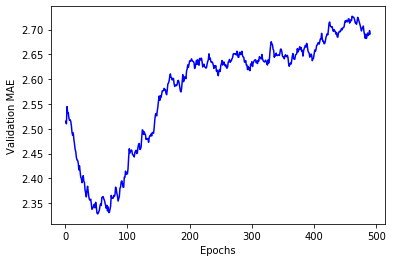

In [8]:
# exponential moving average(smooth curve)

def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
smooth_val_mae_history = smooth_curve(average_val_mae_history[10:])

# plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history, 'red')
plt.plot(range(1, len(smooth_val_mae_history) + 1), smooth_val_mae_history, 'blue')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [16]:
print(smooth_val_mae_history.index(min(smooth_val_mae_history)))
print(min(average_val_mae_history))

51
2.2132398188114166
